In [1]:
#First lets import the necesary libraries
#pennylane for quantum computing.
#numpy from PennyLane for quantum-specific numerical operations.
#RandomLayers for creating random quantum circuits.
#tensorflow and keras for classical machine learning.
#matplotlib.pyplot for plotting.


import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2024-08-09 21:59:31.730159: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-09 21:59:32.773409: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-09 21:59:33.702235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 21:59:34.724593: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 21:59:34.934989: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 21:59:36.377919: I tensorflow/core/platform/cpu_feature_gu

In [13]:
#Setting of the main hyper-parameters and Configuration:
#  Defines parameters for training and dataset sizes.
#  Specifies paths for saving and loading data.
#  Sets random seeds for reproducibility.

n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

# .../_static/demonstration_assets/quanvolution/

SAVE_PATH = ".../_static/demonstration_assets/quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


In [14]:
#Load and Preprocess MNIST Data:


#  Loads the MNIST dataset.
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
#here we define the set for training and for test
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1, so every imagen becomes a matrix of values between 0 and 1.
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels, that means that every pixel becomes a tensor instead of a numeric value
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)


In [53]:
len(train_images[1][1])

28

In [15]:
#Quantum circuit as a convolution kernel 
#First we define the device, here it is the usual simulator
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters to optimize 
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

#Now we define the quantum cirquit and the QNode
@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    #The encoding is an angle encoding, where every qubit is rotaded in the "y" axes by an angle betwee [0,\pi]
    #This is made using an RY rotation, and the angle is calculated by multipling \pi to the value between [0,1] defined in the last box
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement of every qubut producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]


In [5]:
#The next function defines the convolution scheme:
# First the image is divided into squares of 2×2 pixels;
# each square is processed by the quantum circuit;
# the 4 expectation values are mapped into 4 different channels of a single output pixel.

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            #The 2x2 squared matrix is taken as the entries of the initial state, 
            # where the values define the angle encoding of the RY rotation
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values of every 2x2 matrix to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out


In [16]:
#quantum preprocessing the dataset
#this part literally put everithing we have made into action 


if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    #here we made the pre-procesing
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    #here we made the procesing of the test images
    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Here we Save the pre-processed images locally 
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images, its importat that if the process and the images are already done you can 
#set PREPROCESS=False and it will automatically load the images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")


Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


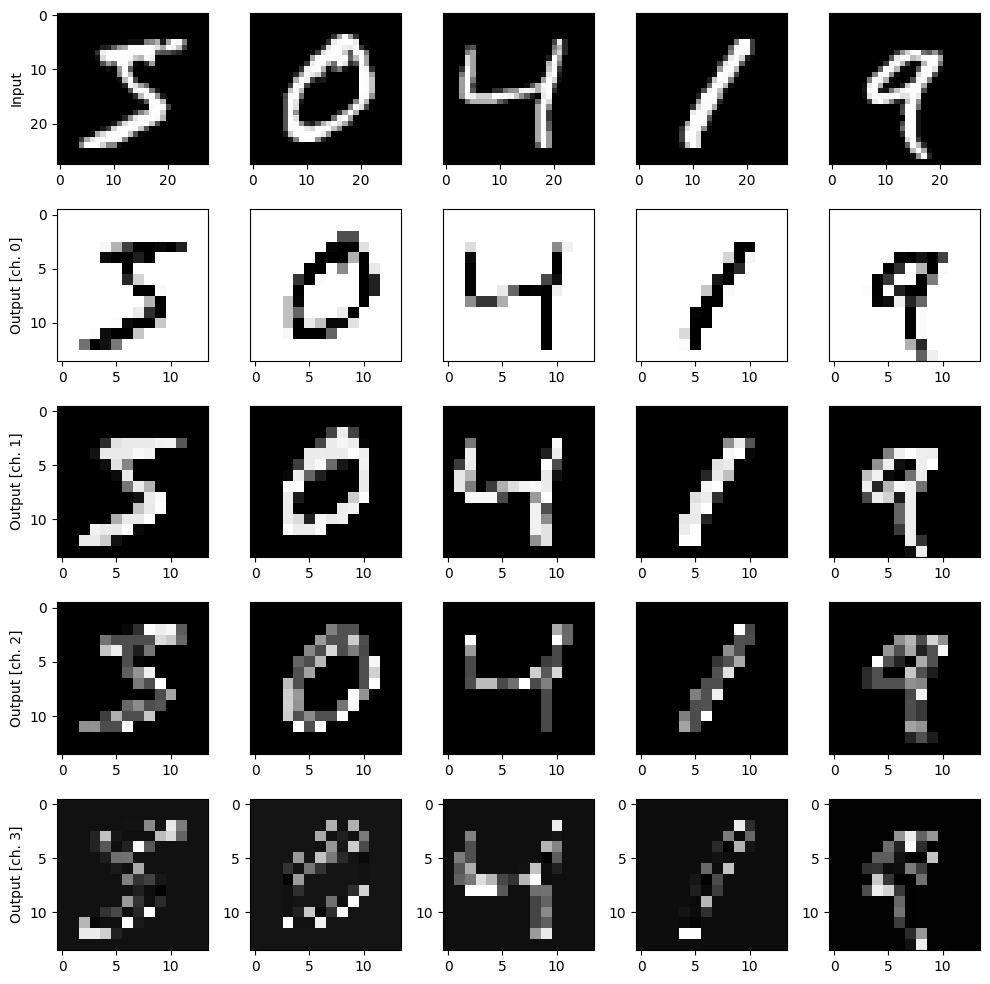

In [7]:
#Here we just visualize the effect of the quantum convolution layer on a batch of samples:

n_samples = 5
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()


In [17]:
#After appying the quantum convolution layer we feed the resulting features into a classical neural network 
# that will be trained to classify the 10 different digits of the MNIST dataset.
# We use a very simple model: just a fully connected layer with 10 output nodes with a final softmax activation function.
# The model is compiled with a stochastic-gradient-descent optimizer, and a cross-entropy loss function.
#This part is classical machine learning 
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [20]:
#Now we apply the classical machine learning layer to the already convolutioned images saved in q_train_images  

q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


Epoch 1/30
13/13 - 1s - 63ms/step - accuracy: 0.1400 - loss: 2.7792 - val_accuracy: 0.2000 - val_loss: 2.3275
Epoch 2/30
13/13 - 0s - 7ms/step - accuracy: 0.2400 - loss: 2.0117 - val_accuracy: 0.2333 - val_loss: 2.1519
Epoch 3/30
13/13 - 0s - 6ms/step - accuracy: 0.4800 - loss: 1.6878 - val_accuracy: 0.3667 - val_loss: 1.9536
Epoch 4/30
13/13 - 0s - 6ms/step - accuracy: 0.7000 - loss: 1.3697 - val_accuracy: 0.4000 - val_loss: 1.7876
Epoch 5/30
13/13 - 0s - 6ms/step - accuracy: 0.8400 - loss: 1.1332 - val_accuracy: 0.4333 - val_loss: 1.6652
Epoch 6/30
13/13 - 0s - 7ms/step - accuracy: 0.9200 - loss: 0.9403 - val_accuracy: 0.5333 - val_loss: 1.5650
Epoch 7/30
13/13 - 0s - 10ms/step - accuracy: 0.9200 - loss: 0.7903 - val_accuracy: 0.5667 - val_loss: 1.4806
Epoch 8/30
13/13 - 0s - 8ms/step - accuracy: 0.9200 - loss: 0.6709 - val_accuracy: 0.5667 - val_loss: 1.4121
Epoch 9/30
13/13 - 0s - 9ms/step - accuracy: 0.9400 - loss: 0.5742 - val_accuracy: 0.5667 - val_loss: 1.3567
Epoch 10/30
13/13

In [19]:
#Here we are gonne apply directly the classical machien learning layer
#without the quantum convolution pre-processing for comparison 

c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 69ms/step - accuracy: 0.1600 - loss: 2.2393 - val_accuracy: 0.1667 - val_loss: 2.1473
Epoch 2/30
13/13 - 0s - 8ms/step - accuracy: 0.5200 - loss: 1.8512 - val_accuracy: 0.2333 - val_loss: 1.9989
Epoch 3/30
13/13 - 0s - 8ms/step - accuracy: 0.6800 - loss: 1.5763 - val_accuracy: 0.3667 - val_loss: 1.8655
Epoch 4/30
13/13 - 0s - 9ms/step - accuracy: 0.8000 - loss: 1.3479 - val_accuracy: 0.4667 - val_loss: 1.7455
Epoch 5/30
13/13 - 0s - 9ms/step - accuracy: 0.8600 - loss: 1.1576 - val_accuracy: 0.5667 - val_loss: 1.6417
Epoch 6/30
13/13 - 0s - 8ms/step - accuracy: 0.9400 - loss: 1.0003 - val_accuracy: 0.5667 - val_loss: 1.5546
Epoch 7/30
13/13 - 0s - 8ms/step - accuracy: 0.9400 - loss: 0.8706 - val_accuracy: 0.7000 - val_loss: 1.4822
Epoch 8/30
13/13 - 0s - 9ms/step - accuracy: 0.9800 - loss: 0.7631 - val_accuracy: 0.7000 - val_loss: 1.4218
Epoch 9/30
13/13 - 0s - 9ms/step - accuracy: 1.0000 - loss: 0.6733 - val_accuracy: 0.7000 - val_loss: 1.3709
Epoch 10/30
13/13 

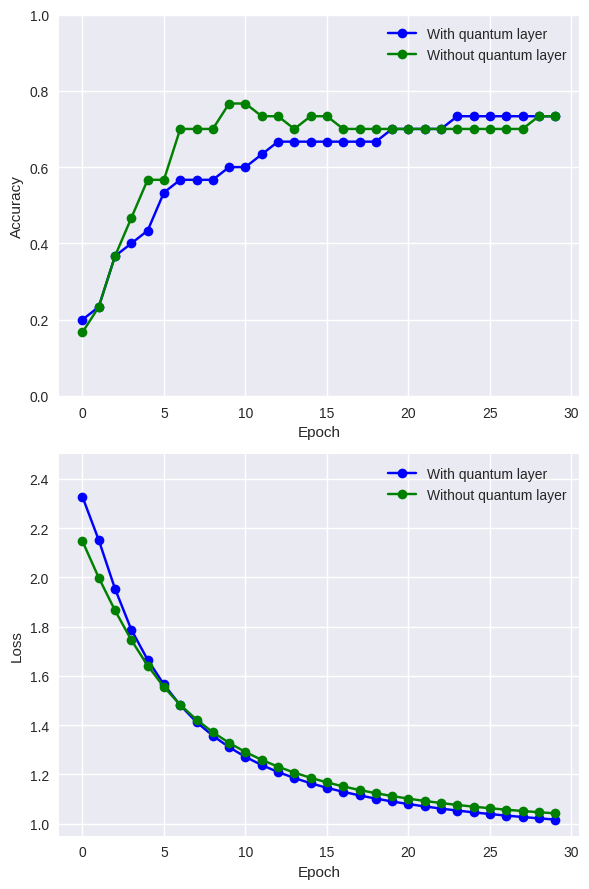

In [21]:
import matplotlib.pyplot as plt

#Here I replace the "seaborn" with the "seaborn-v0_8" since it mark an error
plt.style.use("seaborn-v0_8")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

#In this part we compare the accuravy values of the QML program vs the CML 
ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

#We now compare the history of the values fo the loss function for the QML and the CML programs
ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

#The specific results, and the adventage of one or other might depend on the specific random generation 